# FINAL PROJECT : TOPIC MODELLING (1)
### APPLICATION OF A LDA MODEL (LATENT DIRICHLET ALLOCATION)

- The data provided from Yukka Lab where there are ~10k articles for each day of 2018.
- The documents are already after some preprocessing (e.i. data is already tokenized and sort of cleaned)
- The goal is to cluster the data from the Tokens variable in different topic groups.




In [481]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy

import gensim
from gensim import corpora, models, similarities
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess

import pyLDAvis.gensim

import os, re, operator, warnings

In [421]:
#def read_dataset():
    #with open('en.jsonl', 'r') as infile:
        #for l in infile:
            #yield json.loads(l)
        
#MyList = list(read_dataset())
#len(MyList)
# 362871

362871

In [482]:
class Dataset:
    def __iter__(self):
        with open('en.jsonl', 'r') as infile:
            for l in infile:
                yield json.loads(l)
            
data = Dataset()
type(data)

__main__.Dataset

In [457]:
# Let's have a look what is in the data
for i in data:
    print(i)
    break

{'id': '4634b7327a90b52a0656fd9abb4033d13ceb0eb5', 'title': 'UPDATE 2-Ten people killed in Iran unrest on Sunday -state television.', 'content': '* Anger over corruption and hardship fuels protests -demonstrators.', 'date': '2018-01-01T10:49:44Z', 'tokens': ['anger', 'corruption', 'hardship', 'fuel', 'protest', '-demonstrators'], 'tokens_title': ['update', 'people', 'kill', 'iran', 'unrest', 'sunday', '-state', 'television'], 'entities': [], 'entities_title': ['country:ir'], 'source_id': 9}


In [533]:
# In order to apply the LDA model, Tokens variable will be taken since refers to the content of the data (already after some preprocess)
Tokens = []
for index,doc in enumerate(data):
    Tokens.append(doc['tokens'])
    if index > 10:
        break
        
print(Tokens[:5])
print(type(Tokens))

[['anger', 'corruption', 'hardship', 'fuel', 'protest', '-demonstrators'], ['bureau', 'economic', 'analysis', 'table', 'percent', 'change', 'from', 'preceding', 'period', 'real', 'gross', 'value', 'added', 'sector', 'percent', 'seasonally', 'adjust', 'annual', 'rate', 'last', 'revised', 'january', 'next', 'release', 'date', 'february', 'line', 'gross', 'domestic', 'product', 'business', 'nonfarm', 'farm', 'households', 'institution', 'households', 'nonprofit', 'institution', 'serve', 'household', 'general', 'government', 'federal', 'state', 'local', 'addendum', 'gross', 'house', 'value', 'add', 'line', 'gross', 'domestic', 'product', 'business', 'nonfarm', 'farm', 'households', 'institution', 'households', 'nonprofit', 'institution', 'serve', 'household', 'general', 'government', 'federal', 'state', 'local', 'addendum', 'gross', 'house', 'value', 'add', 'line', 'gross', 'domestic', 'product', 'business', 'nonfarm', 'farm', 'households', 'institution', 'households', 'nonprofit', 'instit

### PREPROCESS
### Check if there are more stop_words inside of my dataset.
After to apply the LDA Model to the whole dataset, among the Top 30 Most Frequent Terms used there are a few stop_words taking the first positions in the rank. Eg. 'the' and 'have'. For that reason, let's have another round of removing stop_words.

In [484]:
import spacy
nlp = spacy.load('en')

import pprint
import re
import string

In [485]:
print(Tokens)

[['anger', 'corruption', 'hardship', 'fuel', 'protest', '-demonstrators'], ['bureau', 'economic', 'analysis', 'table', 'percent', 'change', 'from', 'preceding', 'period', 'real', 'gross', 'value', 'added', 'sector', 'percent', 'seasonally', 'adjust', 'annual', 'rate', 'last', 'revised', 'january', 'next', 'release', 'date', 'february', 'line', 'gross', 'domestic', 'product', 'business', 'nonfarm', 'farm', 'households', 'institution', 'households', 'nonprofit', 'institution', 'serve', 'household', 'general', 'government', 'federal', 'state', 'local', 'addendum', 'gross', 'house', 'value', 'add', 'line', 'gross', 'domestic', 'product', 'business', 'nonfarm', 'farm', 'households', 'institution', 'households', 'nonprofit', 'institution', 'serve', 'household', 'general', 'government', 'federal', 'state', 'local', 'addendum', 'gross', 'house', 'value', 'add', 'line', 'gross', 'domestic', 'product', 'business', 'nonfarm', 'farm', 'households', 'institution', 'households', 'nonprofit', 'instit

In [486]:
# Creating my stop_words function.
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'the', 'say', '---', 'etc', '...', 'but','can'])

[nltk_data] Downloading package punkt to /Users/pilar.ct/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [534]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [255]:
'a' in stop_words

True

In [487]:
for s in Tokens:
    for w in s:
        if w in stop_words: 
            print(w)

from
own
own
the
and
they
the
have
but
have
own
the
have
have
have
but
can
can
the
most
but
have
have
but
have
the
most
but
the
the
while
they
have
have
have
have
the
have
say
use
this
use
why
there
not
while
too
use
there
there
the
for
have
the
the
other
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
other
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
other
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
the
the
the
say
the
have
will
after
have
she
have
say
for
you
have
say
use
the
have
when
say
she
she
the
use
for
the
say
and
say
and
she
the
she
she
have
th

In [495]:
# Remove the sotp_words and filter them into a new list: Filtered_Tokens
Filtered_Tokens = list(map(lambda x: [y for y in x if y not in stop_words] , Tokens))

In [498]:
print(Filtered_Tokens)

[['anger', 'corruption', 'hardship', 'fuel', 'protest', '-demonstrators'], ['bureau', 'economic', 'analysis', 'table', 'percent', 'change', 'preceding', 'period', 'real', 'gross', 'value', 'added', 'sector', 'percent', 'seasonally', 'adjust', 'annual', 'rate', 'last', 'revised', 'january', 'next', 'release', 'date', 'february', 'line', 'gross', 'domestic', 'product', 'business', 'nonfarm', 'farm', 'households', 'institution', 'households', 'nonprofit', 'institution', 'serve', 'household', 'general', 'government', 'federal', 'state', 'local', 'addendum', 'gross', 'house', 'value', 'add', 'line', 'gross', 'domestic', 'product', 'business', 'nonfarm', 'farm', 'households', 'institution', 'households', 'nonprofit', 'institution', 'serve', 'household', 'general', 'government', 'federal', 'state', 'local', 'addendum', 'gross', 'house', 'value', 'add', 'line', 'gross', 'domestic', 'product', 'business', 'nonfarm', 'farm', 'households', 'institution', 'households', 'nonprofit', 'institution', 

In [499]:
# Check if there are duplicates
print(len(Tokens)) ;  print(len(Filtered_Tokens));

12
12


## MODELLING
Once the data has been filtered, the next step it's to create the dictionary and corpus needed for the application of this model.

In [500]:
# Create the Dictionary and Corpus needed for Topic Modeling
# Create the Dictionary
id2word = corpora.Dictionary(Filtered_Tokens)
#print(id2word.__dict__)

# Create Corpus
texts = Filtered_Tokens

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
#print(corpus[:])
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [501]:
# Human readable format of corpus (term-frequency)
#[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:]]
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('-demonstrators', 1),
  ('anger', 1),
  ('corruption', 1),
  ('fuel', 1),
  ('hardship', 1),
  ('protest', 1)]]

In [502]:
# BUILDING TOPIC MODELS (Using the whole Dataset: aprox. 363.000 docs.)

# LDA (LATENT DIRICHLET ALLOCATION) Model
# 10 TOPICS
lda_model_10 = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = id2word,
                                           num_topics = 10,
                                           random_state = 1,
                                           update_every = 1,
                                           chunksize = 363000,
                                           passes = 1,
                                           alpha ='auto',
                                           per_word_topics = True)

/Users/pilar.ct/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/pilar.ct/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/pilar.ct/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * log

In [503]:
# 15 TOPICS
lda_model_15 = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = id2word,
                                           num_topics = 15,
                                           random_state = 1,
                                           update_every = 1,
                                           chunksize = 363000,
                                           passes = 1,
                                           alpha ='auto',
                                           per_word_topics = True)

/Users/pilar.ct/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/pilar.ct/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/pilar.ct/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * log

In [504]:
# 20 TOPICS
lda_model_20 = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = id2word,
                                           num_topics = 20,
                                           random_state = 1,
                                           update_every = 1,
                                           chunksize = 363000,
                                           passes = 1,
                                           alpha ='auto',
                                           per_word_topics = True)

/Users/pilar.ct/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/pilar.ct/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/pilar.ct/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * log

In [505]:
# 25 TOPICS
lda_model_25 = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = id2word,
                                           num_topics = 25,
                                           random_state = 1,
                                           update_every = 1,
                                           chunksize = 363000,
                                           passes = 1,
                                           alpha ='auto',
                                           per_word_topics = True)

/Users/pilar.ct/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/pilar.ct/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/pilar.ct/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * log

In [506]:
# 30 TOPICS
lda_model_30 = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = id2word,
                                           num_topics = 30,
                                           random_state = 1,
                                           update_every = 1,
                                           chunksize = 363000,
                                           passes = 1,
                                           alpha ='auto',
                                           per_word_topics = True)

/Users/pilar.ct/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/pilar.ct/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/pilar.ct/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * log

In [507]:
# 35 TOPICS
lda_model_35 = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = id2word,
                                           num_topics = 35,
                                           random_state = 1,
                                           update_every = 1,
                                           chunksize = 363000,
                                           passes = 1,
                                           alpha ='auto',
                                           per_word_topics = True)

/Users/pilar.ct/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/pilar.ct/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/pilar.ct/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * log

In [508]:
# 40 TOPICS
lda_model_40 = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = id2word,
                                           num_topics = 40,
                                           random_state = 1,
                                           update_every = 1,
                                           chunksize = 363000,
                                           passes = 1,
                                           alpha ='auto',
                                           per_word_topics = True)

/Users/pilar.ct/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/pilar.ct/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/pilar.ct/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * log

In [509]:
# 45 TOPICS
lda_model_45 = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = id2word,
                                           num_topics = 45,
                                           random_state = 1,
                                           update_every = 1,
                                           chunksize = 363000,
                                           passes = 1,
                                           alpha ='auto',
                                           per_word_topics = True)

/Users/pilar.ct/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/pilar.ct/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/pilar.ct/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * log

In [510]:
# 49 TOPICS
lda_model_49 = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = id2word,
                                           num_topics = 49,
                                           random_state = 1,
                                           update_every = 1,
                                           chunksize = 363000,
                                           passes = 1,
                                           alpha ='auto',
                                           per_word_topics = True)

/Users/pilar.ct/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/pilar.ct/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/pilar.ct/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * log

In [523]:
# 50 TOPICS
lda_model_50 = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = id2word,
                                           num_topics = 50,
                                           random_state = 1,
                                           update_every = 1,
                                           chunksize = 363000,
                                           passes = 1,
                                           alpha ='auto',
                                           per_word_topics = True)

/Users/pilar.ct/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/pilar.ct/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/pilar.ct/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * log

### TOPIC COHERENCE
Topic coherence helps to get past manually inspecting the topic models - Now it is possible to keep fine tuning the models and compare between them to see which has the best performance, since perplexity might not be such a good metric, because – in short – it is context-free (i.e, it does not capture semantic information).


In [512]:
# TOPIC COHERENCE
ldatopics_10 = [[word for word, prob in topic] for topicid, topic in lda_model_10.show_topics(formatted=False)]

ldatopics_15 = [[word for word, prob in topic] for topicid, topic in lda_model_15.show_topics(formatted=False)]

ldatopics_20 = [[word for word, prob in topic] for topicid, topic in lda_model_20.show_topics(formatted=False)]

ldatopics_25 = [[word for word, prob in topic] for topicid, topic in lda_model_25.show_topics(formatted=False)]

ldatopics_30 = [[word for word, prob in topic] for topicid, topic in lda_model_30.show_topics(formatted=False)]

ldatopics_35 = [[word for word, prob in topic] for topicid, topic in lda_model_35.show_topics(formatted=False)]

ldatopics_40 = [[word for word, prob in topic] for topicid, topic in lda_model_40.show_topics(formatted=False)]

ldatopics_45 = [[word for word, prob in topic] for topicid, topic in lda_model_45.show_topics(formatted=False)]

ldatopics_49 = [[word for word, prob in topic] for topicid, topic in lda_model_49.show_topics(formatted=False)]

ldatopics_50 = [[word for word, prob in topic] for topicid, topic in lda_model_50.show_topics(formatted=False)]

In [513]:
dictionary = id2word

lda_coherence_10 = CoherenceModel(topics=ldatopics_10, texts=texts, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence_15 = CoherenceModel(topics=ldatopics_15, texts=texts, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence_20 = CoherenceModel(topics=ldatopics_20, texts=texts, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence_25 = CoherenceModel(topics=ldatopics_25, texts=texts, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence_30 = CoherenceModel(topics=ldatopics_30, texts=texts, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence_35 = CoherenceModel(topics=ldatopics_35, texts=texts, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence_40 = CoherenceModel(topics=ldatopics_40, texts=texts, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence_45 = CoherenceModel(topics=ldatopics_45, texts=texts, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence_49 = CoherenceModel(topics=ldatopics_49, texts=texts, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence_50 = CoherenceModel(topics=ldatopics_50, texts=texts, dictionary=dictionary, window_size=10).get_coherence()

In [444]:
# pyLDAVvis
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

In [514]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.5, tick_label=indices, align='center', color='cornflowerblue')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

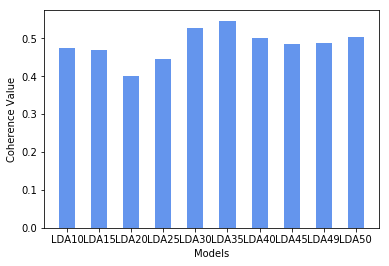

In [515]:
evaluate_bar_graph([lda_coherence_10, lda_coherence_15, lda_coherence_20, lda_coherence_25, lda_coherence_30, 
                    lda_coherence_35, lda_coherence_40,lda_coherence_45, lda_coherence_49, lda_coherence_50], 
                   ['LDA10', 'LDA15', 'LDA20','LDA25','LDA30','LDA35','LDA40','LDA45','LDA49','LDA50'])

In [522]:
import pprint

pprint.pprint(lda_model_30.print_topics())
doc_lda_30 = lda_model_30[corpus]

[(3,
  '0.024*"board" + 0.016*"culture" + 0.014*"hospital" + 0.010*"organization" + '
  '0.010*"result" + 0.005*"company" + 0.005*"corporate" + 0.004*"issue" + '
  '0.004*"include" + 0.004*"work"'),
 (2,
  '0.020*"report" + 0.020*"misconduct" + 0.020*"sexual" + 0.020*"president" + '
  '0.020*"fund" + 0.020*"woman" + 0.020*"unsuccessful" + 0.020*"sunday" + '
  '0.020*"rich" + 0.020*"york"'),
 (25,
  '0.006*"board" + 0.004*"build" + 0.004*"secoy" + 0.003*"culture" + '
  '0.003*"organization" + 0.003*"hospital" + 0.003*"ice" + 0.003*"jensen" + '
  '0.003*"work" + 0.003*"house"'),
 (1,
  '0.028*"vehicle" + 0.027*"light" + 0.025*"auto" + 0.024*"truck" + '
  '0.024*"new" + 0.019*"used" + 0.016*"output" + 0.015*"trucks" + '
  '0.015*"utility" + 0.013*"motor"'),
 (11,
  '0.013*"build" + 0.011*"secoy" + 0.009*"jensen" + 0.009*"property" + '
  '0.009*"work" + 0.008*"design" + 0.008*"ice" + 0.007*"board" + '
  '0.007*"facility" + 0.006*"tenant"'),
 (24,
  '0.016*"board" + 0.013*"culture" + 0.010*

In [521]:
pprint.pprint(lda_model_35.print_topics())
doc_lda_35 = lda_model_35[corpus]

[(2,
  '0.001*"islands" + 0.001*"island" + 0.001*"murphy" + 0.001*"mise" + '
  '0.001*"law" + 0.001*"landmass" + 0.001*"portland" + 0.001*"hardcover" + '
  '0.001*"internationaux" + 0.001*"relating"'),
 (17,
  '0.003*"safety" + 0.003*"robot" + 0.002*"risk" + 0.002*"standard" + '
  '0.002*"requirement" + 0.002*"hazard" + 0.002*"system" + 0.002*"industrial" '
  '+ 0.002*"collaborative" + 0.002*"ria"'),
 (33,
  '0.023*"board" + 0.017*"culture" + 0.009*"hospital" + 0.008*"organization" + '
  '0.007*"result" + 0.006*"corporate" + 0.005*"company" + 0.004*"issue" + '
  '0.004*"work" + 0.004*"include"'),
 (9,
  '0.017*"build" + 0.013*"jensen" + 0.012*"house" + 0.011*"work" + 0.011*"ice" '
  '+ 0.011*"property" + 0.010*"secoy" + 0.008*"design" + 0.008*"industrial" + '
  '0.008*"tenant"'),
 (15,
  '0.031*"robot" + 0.015*"safety" + 0.010*"risk" + 0.009*"standard" + '
  '0.009*"requirement" + 0.007*"industrial" + 0.007*"hazard" + '
  '0.006*"assessment" + 0.005*"ria" + 0.005*"system"'),
 (34,
  '0

In [529]:
pprint.pprint(lda_model_50.print_topics())
doc_lda_50 = lda_model_50[corpus]

[(47,
  '0.001*"islands" + 0.001*"island" + 0.001*"murphy" + 0.001*"mise" + '
  '0.001*"law" + 0.001*"landmass" + 0.001*"portland" + 0.001*"hardcover" + '
  '0.001*"internationaux" + 0.001*"relating"'),
 (20,
  '0.001*"islands" + 0.001*"island" + 0.001*"murphy" + 0.001*"mise" + '
  '0.001*"law" + 0.001*"landmass" + 0.001*"portland" + 0.001*"hardcover" + '
  '0.001*"internationaux" + 0.001*"relating"'),
 (11,
  '0.001*"islands" + 0.001*"island" + 0.001*"murphy" + 0.001*"mise" + '
  '0.001*"law" + 0.001*"landmass" + 0.001*"portland" + 0.001*"hardcover" + '
  '0.001*"internationaux" + 0.001*"relating"'),
 (9,
  '0.002*"build" + 0.002*"jensen" + 0.002*"work" + 0.002*"house" + '
  '0.002*"property" + 0.002*"ice" + 0.002*"secoy" + 0.002*"tenant" + '
  '0.002*"space" + 0.002*"design"'),
 (14,
  '0.012*"build" + 0.011*"house" + 0.010*"secoy" + 0.009*"ice" + 0.008*"work" '
  '+ 0.007*"design" + 0.007*"property" + 0.006*"jensen" + 0.006*"tenant" + '
  '0.005*"space"'),
 (10,
  '0.020*"board" + 0

In [537]:
# Visualize the LDA topics with more coherence according to the bar graph above
pyLDAvis.enable_notebook()
LDAvis_30 = pyLDAvis.gensim.prepare(lda_model_30, corpus, id2word) 
LDAvis_30

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
26    -0.112665  0.006924       1        1  23.681881
0     -0.029609 -0.041296       2        1  22.695436
21     0.303978  0.008192       3        1  16.158905
10    -0.044695 -0.186447       4        1  16.096912
7      0.139069 -0.162495       5        1   6.469132
12    -0.054307  0.170184       6        1   5.164538
14    -0.011342  0.075095       7        1   4.543476
8      0.090767  0.066617       8        1   2.697567
2     -0.022917  0.001910       9        1   0.849909
22    -0.029977 -0.004645      10        1   0.645376
27    -0.046959 -0.035117      11        1   0.436881
16    -0.055193 -0.058864      12        1   0.230572
29     0.000059  0.105321      13        1   0.021126
23    -0.007940 -0.050204      14        1   0.020880
15    -0.027321 -0.036749      15        1   0.020646
28    -0.082428  0.037278      16        1   0.019576
13    -0.020895 -0.086167      17        1   0.019570
19     0.009768  0.060058      18        1   0.019518
5     -0.004268 -0.064995      19        1   0.019431
6      0.028168  0.077840      20        1   0.018173
4      0.163929  0.040098      21        1   0.018032
17    -0.052797  0.062695      22        1   0.018012
20    -0.042072  0.007859      23        1   0.018011
9     -0.026744  0.010345      24        1   0.017876
18    -0.037351  0.074855      25        1   0.017374
24    -0.052196 -0.025141      26        1   0.016559
11    -0.029161 -0.005835      27        1   0.016550
1      0.115069  0.026437      28        1   0.016539
25    -0.019042 -0.009598      29        1   0.016440
3     -0.040927 -0.064153      30        1   0.015101, topic_info=     Category       Freq           Term      Total  loglift  logprob
term                                                                
87    Default  31.000000          board  31.000000  30.0000  30.0000
514   Default  23.000000          robot  23.000000  29.0000  29.0000
326   Default  27.000000            new  27.000000  28.0000  28.0000
583   Default  22.000000          truck  22.000000  27.0000  27.0000
520   Default  21.000000         safety  21.000000  26.0000  26.0000
559   Default  23.000000           auto  23.000000  25.0000  25.0000
588   Default  20.000000        vehicle  20.000000  24.0000  24.0000
118   Default  23.000000        culture  23.000000  23.0000  23.0000
573   Default  19.000000          light  19.000000  22.0000  22.0000
180   Default  19.000000        include  19.000000  21.0000  21.0000
586   Default  15.000000           used  15.000000  20.0000  20.0000
560   Default  15.000000          autos  15.000000  19.0000  19.0000
20    Default  18.000000       domestic  18.000000  18.0000  18.0000
534   Default  15.000000       standard  15.000000  17.0000  17.0000
685   Default  12.000000          build  12.000000  16.0000  16.0000
175   Default  15.000000       hospital  15.000000  15.0000  15.0000
33    Default  14.000000          house  14.000000  14.0000  14.0000
32    Default  13.000000          gross  13.000000  13.0000  13.0000
584   Default  13.000000         trucks  13.000000  12.0000  12.0000
272   Default  12.000000           risk  12.000000  11.0000  11.0000
315   Default  13.000000           work  13.000000  10.0000  10.0000
230   Default  14.000000   organization  14.000000   9.0000   9.0000
426   Default  11.000000     industrial  11.000000   8.0000   8.0000
577   Default  11.000000         output  11.000000   7.0000   7.0000
849   Default   9.000000          secoy   9.000000   6.0000   6.0000
245   Default  12.000000        private  12.000000   5.0000   5.0000
574   Default  10.000000          motor  10.000000   4.0000   4.0000
766   Default  10.000000         jensen  10.000000   3.0000   3.0000
587   Default  10.000000        utility  10.000000   2.0000   2.0000
294   Default  11.000000         system  11.000000   1.0000   1.0000
...       ...        

In [535]:
LDAvis_35 = pyLDAvis.gensim.prepare(lda_model_35, corpus, id2word) 
LDAvis_35

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
26    -0.157120  0.108472       1        1  30.123520
0      0.079493  0.002437       2        1  23.541363
21     0.288293 -0.032250       3        1  16.153517
12    -0.059851  0.198421       4        1   9.973096
3     -0.072574 -0.077533       5        1   9.096514
7      0.142189 -0.121501       6        1   6.468111
16    -0.024204 -0.163880       7        1   1.948635
11    -0.007136  0.005760       8        1   0.961246
8      0.137512  0.035186       9        1   0.706738
23    -0.090314  0.007908      10        1   0.436843
6      0.052379  0.124489      11        1   0.229078
29     0.047199  0.076276      12        1   0.017017
31     0.089112  0.053981      13        1   0.016969
28    -0.070156  0.014479      14        1   0.016889
30    -0.017694  0.063470      15        1   0.016876
13    -0.016005 -0.107181      16        1   0.016833
4      0.169118  0.069419      17        1   0.015761
32     0.036518 -0.027328      18        1   0.015752
19     0.016719  0.049201      19        1   0.015718
1      0.106911  0.049575      20        1   0.015677
24    -0.076351 -0.043484      21        1   0.015627
10    -0.007810 -0.165447      22        1   0.015590
18    -0.046301 -0.051001      23        1   0.015326
20    -0.016296 -0.004020      24        1   0.014522
5     -0.096432  0.018522      25        1   0.014521
27    -0.080844 -0.027250      26        1   0.014487
22    -0.011096 -0.017259      27        1   0.014473
25    -0.051552 -0.058478      28        1   0.014464
14    -0.060548 -0.029106      29        1   0.014439
34    -0.046009  0.017728      30        1   0.014411
15    -0.058370  0.061368      31        1   0.014324
9      0.001134  0.005703      32        1   0.013238
33    -0.052463 -0.047434      33        1   0.013220
17    -0.025621  0.009828      34        1   0.013135
2     -0.021832  0.000928      35        1   0.012072, topic_info=     Category       Freq                 Term      Total  loglift  logprob
term                                                                      
514   Default  30.000000                robot  30.000000  30.0000  30.0000
326   Default  32.000000                  new  32.000000  29.0000  29.0000
520   Default  26.000000               safety  26.000000  28.0000  28.0000
583   Default  25.000000                truck  25.000000  27.0000  27.0000
559   Default  27.000000                 auto  27.000000  26.0000  26.0000
588   Default  22.000000              vehicle  22.000000  25.0000  25.0000
573   Default  22.000000                light  22.000000  24.0000  24.0000
87    Default  16.000000                board  16.000000  23.0000  23.0000
180   Default  19.000000              include  19.000000  22.0000  22.0000
534   Default  18.000000             standard  18.000000  21.0000  21.0000
586   Default  18.000000                 used  18.000000  20.0000  20.0000
685   Default  13.000000                build  13.000000  19.0000  19.0000
560   Default  18.000000                autos  18.000000  18.0000  18.0000
118   Default  13.000000              culture  13.000000  17.0000  17.0000
20    Default  19.000000             domestic  19.000000  16.0000  16.0000
33    Default  14.000000                house  14.000000  15.0000  15.0000
426   Default  13.000000           industrial  13.000000  14.0000  14.0000
272   Default  13.000000                 risk  13.000000  13.0000  13.0000
584   Default  15.000000               trucks  15.000000  12.0000  12.0000
315   Default  11.000000                 work  11.000000  11.0000  11.0000
849   Default  10.000000                secoy  10.000000  10.0000  10.0000
766   Default  10.000000               jensen  10.000000   9.0000   9.0000
757   Default  10.000000                  ice  10.000000   8.0000   8.0000
577   Default  13.000000               output  13.000000   7.0000   7.0000
32    Def

In [536]:
pyLDAvis.enable_notebook()
LDAvis_50 = pyLDAvis.gensim.prepare(lda_model_50, corpus, id2word) 
LDAvis_50

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
26    -0.133109 -0.027916       1        1  23.109537
0     -0.051393  0.071614       2        1  22.574358
43    -0.114876 -0.050923       3        1  16.226269
21     0.433096 -0.039828       4        1  16.148897
16     0.102101 -0.190333       5        1   6.828724
35    -0.012614 -0.094189       6        1   5.345180
12    -0.068423 -0.026068       7        1   4.536320
41     0.124948  0.005864       8        1   2.729689
2     -0.009355 -0.018946       9        1   0.846654
7      0.104889 -0.185978      10        1   0.641103
8      0.005968  0.109085      11        1   0.393772
13    -0.037397 -0.117747      12        1   0.225029
29     0.054855  0.096717      13        1   0.012197
6     -0.019649  0.022728      14        1   0.012155
36    -0.070548  0.001018      15        1   0.012143
49     0.172588  0.136411      16        1   0.011405
5     -0.042434 -0.134735      17        1   0.011381
31     0.142683  0.076823      18        1   0.011330
48     0.024883  0.055653      19        1   0.011305
30    -0.025670  0.054751      20        1   0.011293
34     0.007871 -0.085229      21        1   0.011278
22    -0.028450  0.047673      22        1   0.011233
15    -0.056679  0.058482      23        1   0.011203
19    -0.058700  0.135263      24        1   0.010524
39    -0.043480  0.134631      25        1   0.010509
1      0.159782 -0.004539      26        1   0.010498
32     0.030378  0.166090      27        1   0.010492
44    -0.030338  0.076800      28        1   0.010485
28    -0.050112  0.047315      29        1   0.010478
24    -0.078342 -0.087236      30        1   0.010470
46    -0.036175  0.015081      31        1   0.010466
42    -0.032837  0.030232      32        1   0.010453
27    -0.053098 -0.049162      33        1   0.010451
23    -0.063912 -0.076820      34        1   0.010435
37     0.020296 -0.041153      35        1   0.010406
40    -0.099251  0.028974      36        1   0.009657
4      0.257223 -0.024094      37        1   0.009650
45    -0.018297  0.107122      38        1   0.009643
33    -0.063787 -0.075103      39        1   0.009639
18    -0.057377 -0.066898      40        1   0.009636
3     -0.058187 -0.065748      41        1   0.009635
14    -0.016604  0.050770      42        1   0.009626
10    -0.043860 -0.043887      43        1   0.009625
25    -0.041374 -0.042306      44        1   0.009624
38    -0.016656  0.042033      45        1   0.009622
17    -0.040575  0.000876      46        1   0.009618
9     -0.016574  0.000939      47        1   0.009585
47    -0.017142 -0.008036      48        1   0.008771
11    -0.017142 -0.008036      49        1   0.008771
20    -0.017142 -0.008036      50        1   0.008771, topic_info=     Category      Freq                 Term      Total  loglift  logprob
term                                                                     
514   Default  30.00000                robot  30.000000  30.0000  30.0000
87    Default  28.00000                board  28.000000  29.0000  29.0000
520   Default  27.00000               safety  27.000000  28.0000  28.0000
326   Default  30.00000                  new  30.000000  27.0000  27.0000
583   Default  25.00000                truck  25.000000  26.0000  26.0000
559   Default  25.00000                 auto  25.000000  25.0000  25.0000
588   Default  20.00000              vehicle  20.000000  24.0000  24.0000
118   Default  20.00000              culture  20.000000  23.0000  23.0000
573   Default  20.00000                light  20.000000  22.0000  22.0000
534   Default  19.00000             standard  19.000000  21.0000  21.0000
180   Default  19.00000              include  19.000000  20.0000  20.0000
560   Default  18.00000                autos  18.000000  19.0000  19.0000
586   Default  17.00000                 used  17.000000  18.0000  18.0000
20    Default  21.00000             dom